# Python Operator
This example shows how to implement and use a custom python operator.

## Defining an operator implementation

In [1]:
import numpy as np

def blue_channel_normalize_flip(image):
    return np.fliplr(image[:, :, 2] / 255.)

The function above defines a simple operation on a RGB image given as a numpy array. Generally a python operator implementation must be a function that consumes and produces single numpy array.

## Example pipeline

In [2]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

image_dir = 'images'

class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, _seed, image_dir):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed=_seed, exec_async=False,
                                             exec_pipelined=False)
        self.input = ops.FileReader(file_root=image_dir)
        self.decode = ops.HostDecoder(output_type=types.RGB)
        self.normalize_flip = ops.PythonFunction(function=blue_channel_normalize_flip)

    def define_graph(self):
        jpegs, labels = self.input()
        decoded = self.decode(jpegs)
        normalized_flipped = self.normalize_flip(decoded)
        return normalized_flipped

Our custom python operator is introduced into pipeline as `PythonFunction`. The function object is passed as a named argument. Please notice that for now custom python operators work only in pipelines with `exec_async=False` and `exec_pipelined=False` specified.

## Running the pipeline and visualizing results

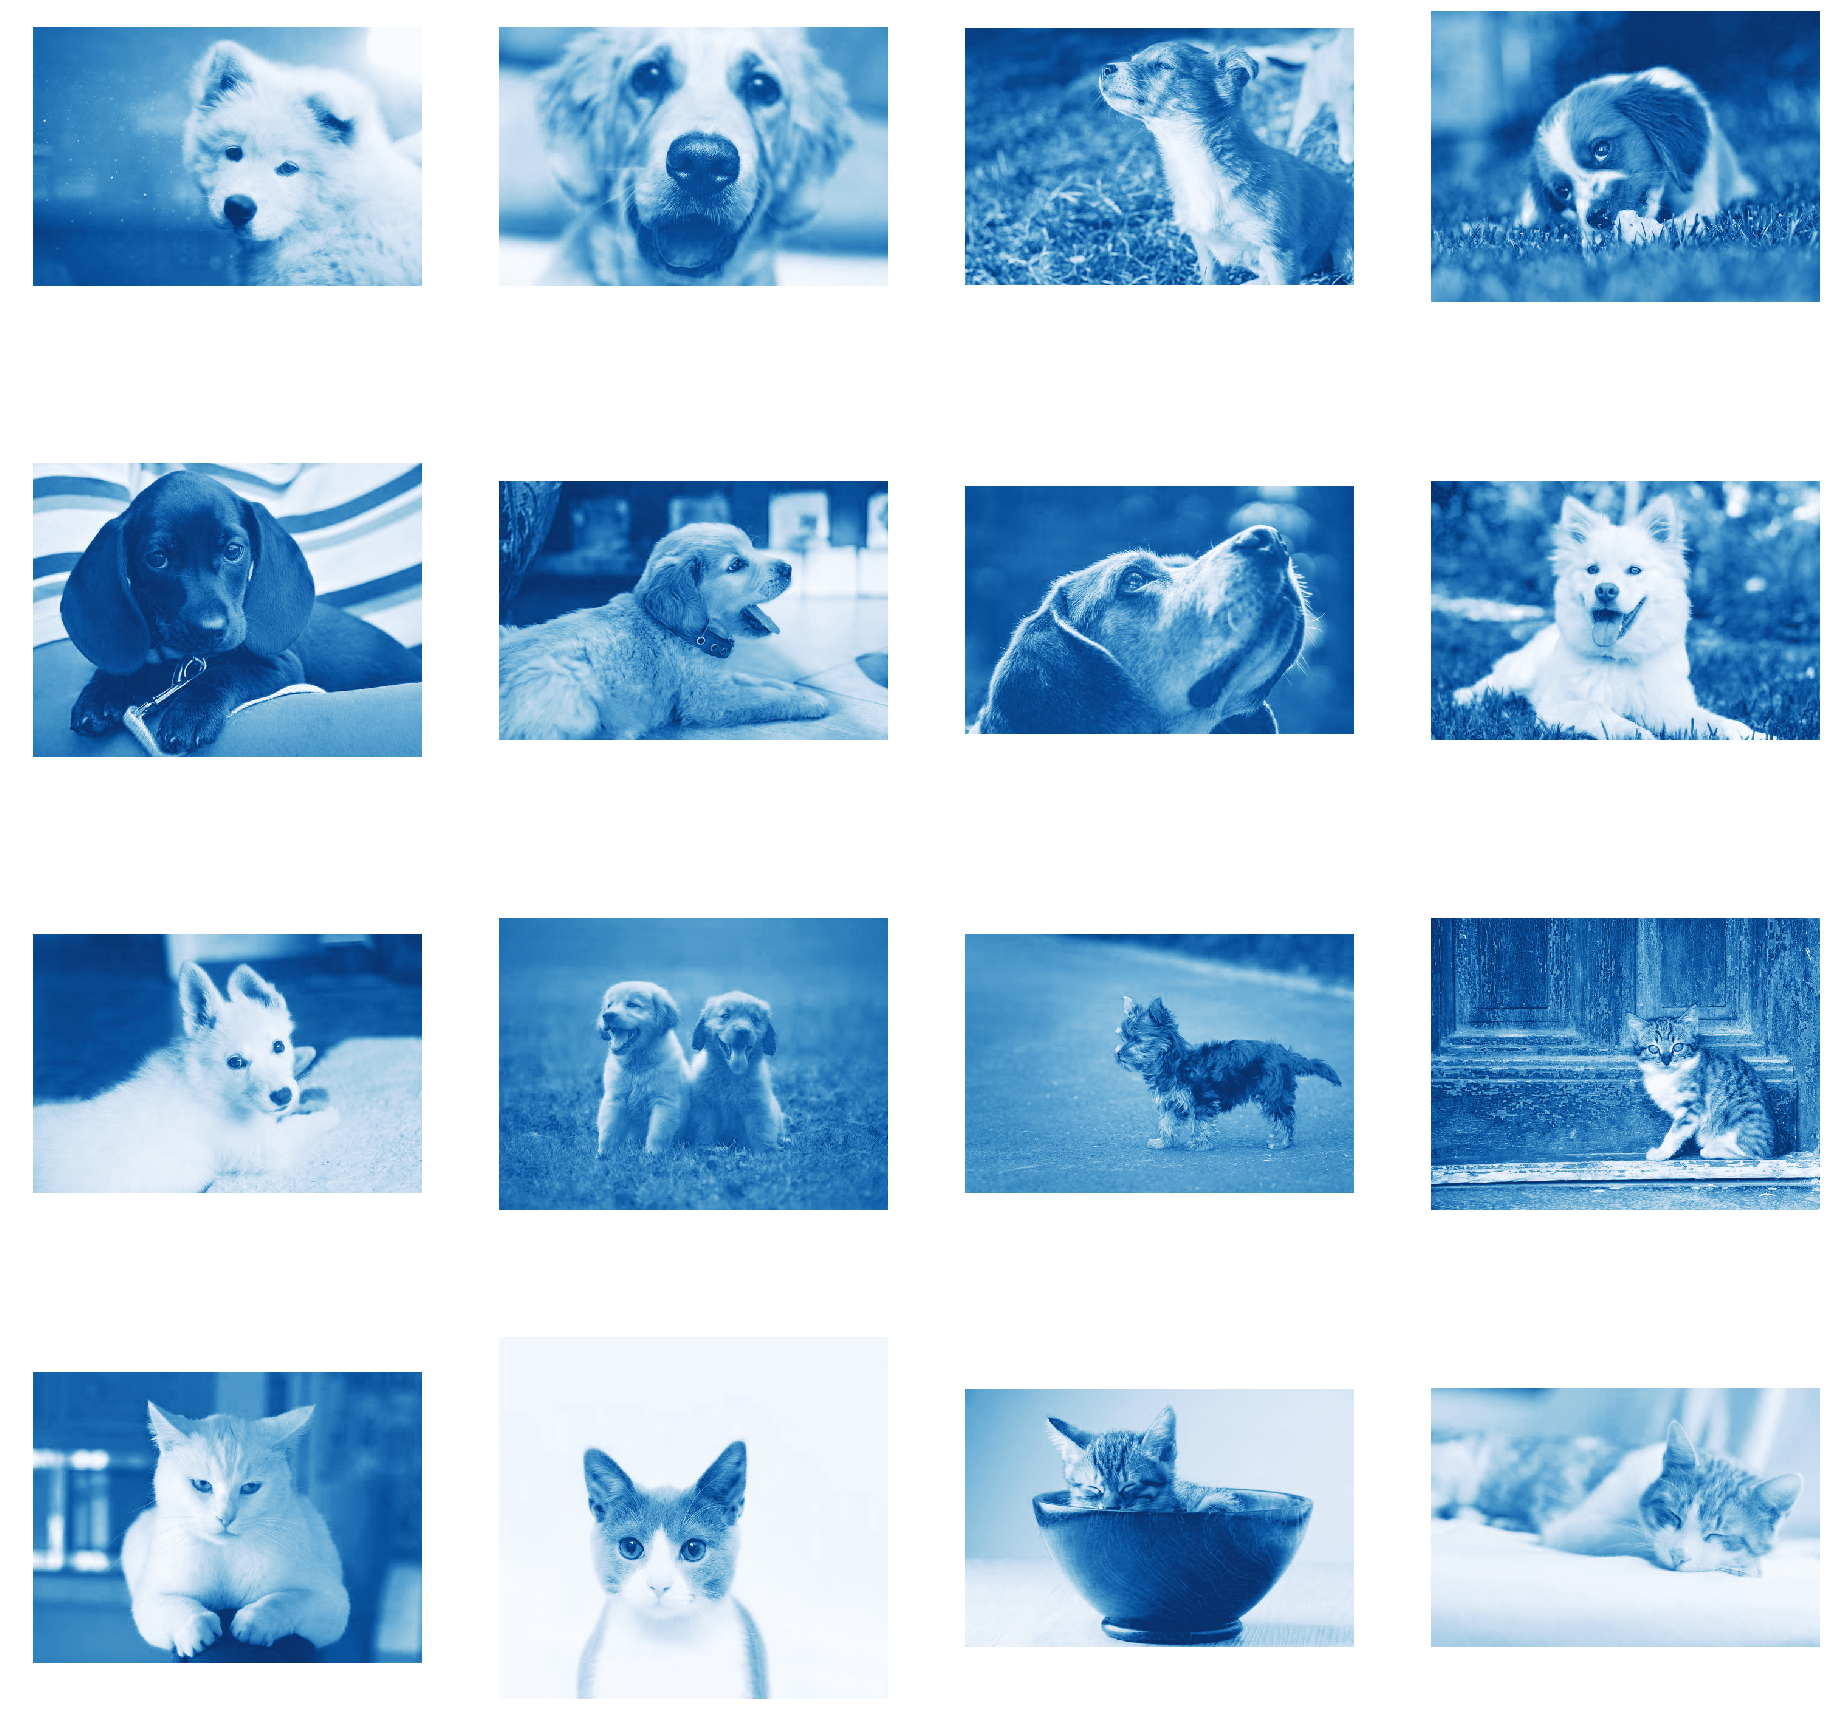

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline

batch_size = 16

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j), cmap=plt.get_cmap('Blues_r'))
        
        
pipe = SimplePipeline(batch_size, 4, 0, 12, image_dir)
pipe.build()
outputs, = pipe.run()

show_images(outputs)